In [1]:
import xarray as xr
import glob
import os
import regex as re
import matplotlib.pyplot as plt
import pandas as pd
from dask.diagnostics import ProgressBar

In [2]:
rootdir = '/projects/SOCCOM/scratch/gpfs/graemem/'
rootdir_jra = rootdir+'jra55/monthly/'
rootdir_sos = '/scratch/gpfs/graemem/en4/EN.4.2.2_regridded/'
rootdir_wmt = rootdir+'jra55_wmt/'
ppname = '*'
year = '*'
filename = ppname+'.*.'+str(year)+'*.nc'
pathstr = rootdir_jra+ppname+'/'+str(year)+'/'+filename
paths = glob.glob(pathstr)
paths[0]

'/projects/SOCCOM/scratch/gpfs/graemem/jra55/monthly/anl_p25/1968/anl_p25.052_rh.196801_196812.nc'

In [3]:
# Grab only the paths for the variables of interest
variables = ['brtmp','dlwrf','dswrf',
             'evp','lhtfl',
             'shtfl','tprat','ulwrf','uswrf']
# variables = ['brtmp']
reg = re.compile(r"\L<variables>", variables=variables)
pathsnow = list(filter(reg.search, paths))

In [4]:
pathsnow[0]

'/projects/SOCCOM/scratch/gpfs/graemem/jra55/monthly/fcst_phy2m/1968/fcst_phy2m.061_tprat.reg_tl319.196801_196812.nc'

In [5]:
def preprocess(ds):
    filename = ds.encoding["source"]
    # Rename variable
    title = re.search(r'\.(.*?)\.', filename).group(1)
    num = title[0:3]
    new = title[4:]
    orig = 'var'+str(int(num))
    # Respecify time (set to approx. middle of month)
    year = re.search(r'01_(.*?)12.nc', filename).group(1)
    times = pd.date_range(year+'-01-16',periods=12,freq='M')-pd.DateOffset(days=15)
    return ds.rename({orig:new}).assign_coords({'time':times})

In [6]:
ds = xr.open_mfdataset(pathsnow,preprocess=preprocess)
ds = ds.sortby('lat').chunk({'time':120})

In [7]:
ds_wmt = xr.Dataset()
# Calculate terms
ds_wmt['tos'] = ds['brtmp']-273.15
ds_wmt['hfds'] = (ds['dlwrf']-ds['ulwrf']+ds['dswrf']-ds['uswrf']-ds['lhtfl']-ds['shtfl'])
conv = (1/1000)*1000*(1/86400) # mm d-1 ---> kg m-2 s-1
ds_wmt['wfo'] = (ds['tprat']-ds['evp'])*conv

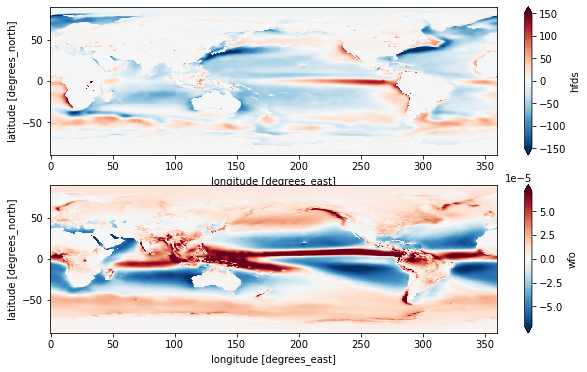

In [8]:
fig,(ax1,ax2) = plt.subplots(figsize=(10,6),nrows=2)
ds_wmt['hfds'].isel(time=slice(-240,-1)).mean('time').plot(ax=ax1,robust=True,vmin=-150,vmax=150,cmap='RdBu_r')
ds_wmt['wfo'].isel(time=slice(-240,-1)).mean('time').plot(ax=ax2,robust=True)

In [9]:
### Get SoS from en4
sos = xr.open_zarr(rootdir_sos+'jra55.zarr')['salinity']
sos_wmt = (sos.
           sel(time=ds['time'],method='nearest',drop=True).
           assign_coords(ds.coords).
           chunk({'time':120}))
ds_wmt['sos'] = sos_wmt

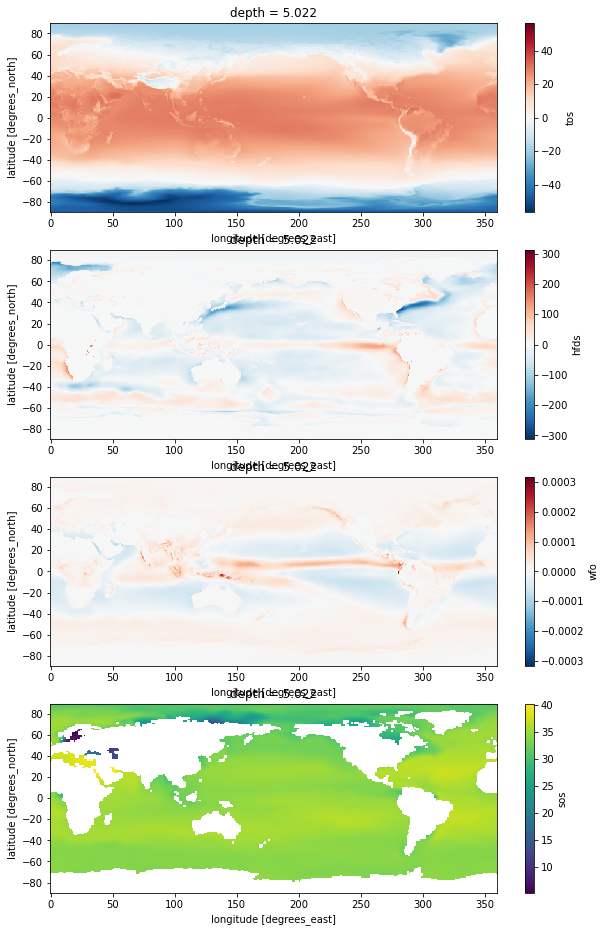

In [10]:
nv = len(ds_wmt.data_vars)
fig,ax = plt.subplots(figsize=(10,4*nv),nrows=nv)
for i,varname in enumerate(ds_wmt.data_vars):
    da = ds_wmt[varname].isel(time=slice(0,120)).mean('time')
    da.plot(ax=ax[i])

In [11]:
with ProgressBar():
    ds_wmt.to_zarr(rootdir_wmt+'jra55.en4.ds.zarr',mode='w')

[########################################] | 100% Completed | 3.77 sms
